# Gaussian Mixture + Naive Bayes
We implement the Gaussian mixture naive Bayes model to predict Santander Customer Transaction Prediction data. The problem has a binary target and 200 continuous features, and we assume that these features are conditionally independent given the class. We model the target  Y  as Bernoulli, taking values 0 (negative) and 1 (positive). The features  $$X_0,X_1,…,X_{199}$$ are modelled as continuous random variables. 

$$p_{Y|X_0,X_1,\ldots,X_{199}}(y|x_0,x_1,\ldots,x_{199})=\frac{p_Y(y)\prod_{i=0}^{199}f_{X_i|Y}(x_i|y)}{\sum_{y'=0}^1p_Y(y')\prod_{i=0}^{199}f_{X_i|Y}(x_i|y')}$$

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
train.loc[0,['target','var_0']]

target         0
var_0     8.9255
Name: 0, dtype: object

Train set contains:

+ ID_code (string);
+ target;
+ 200 numerical variables, named from var_0 to var_199;

In [4]:
X_train = train.iloc[:, 2:].values.astype('float64')
y_train = train['target'].values

In [5]:
train.describe()#考虑归一化后再看特征的分布

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [6]:
train[0:2]

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


### Distribution of target value

It shows data is unbalanced with respect with **target** value.

d:\python机器学习\其他\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

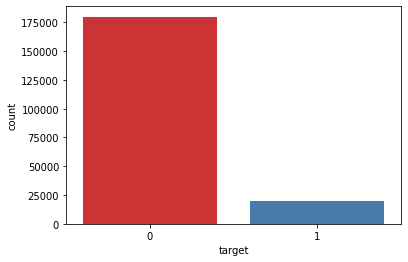

In [7]:
sns.countplot(train['target'], palette='Set1')

### Density plots of features
We represent with different colors the distribution for values with target value 0 and 1.

The first 100 values are displayed in the following cell. 

In [8]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(20,30))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

d:\python机器学习\其他\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
d:\python机器学习\其他\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
d:\python机器学习\其他\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (

<Figure size 432x288 with 0 Axes>

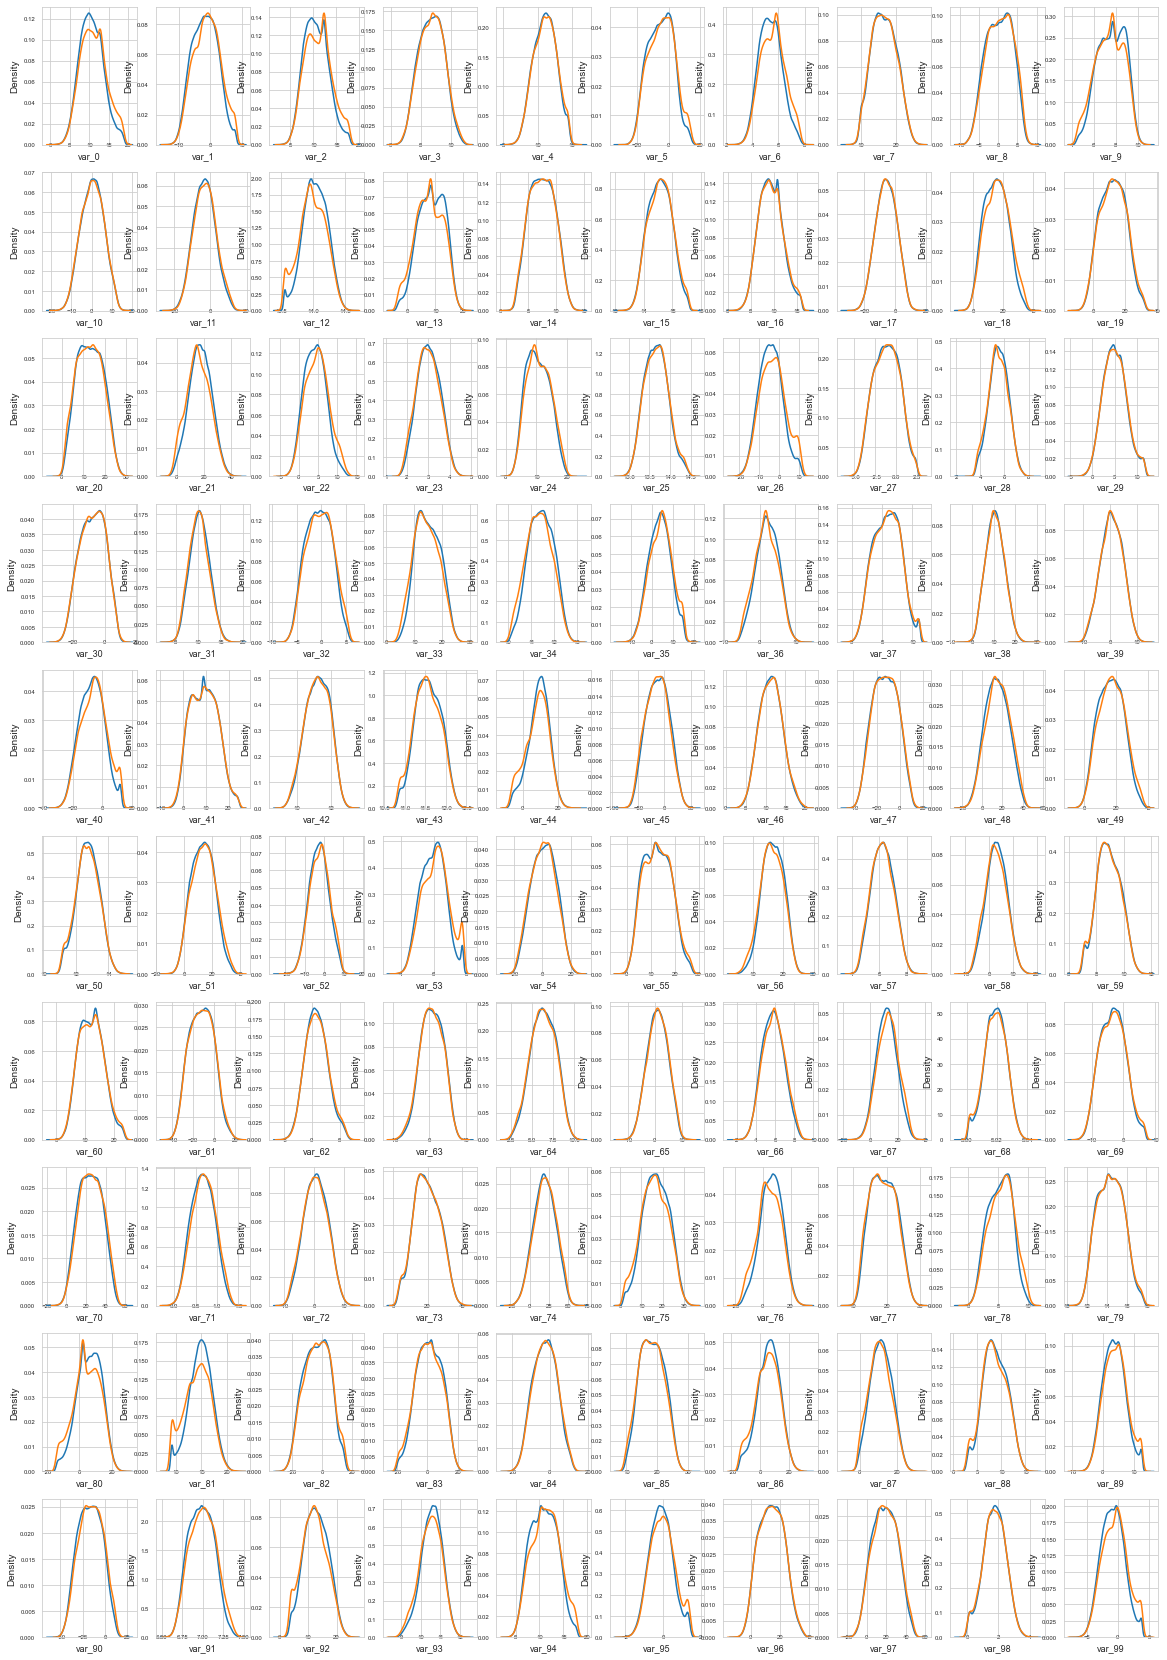

In [9]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]#将column压平
plot_feature_distribution(t0, t1, '0', '1', features)

We can observe that there is a considerable number of features with significant different distribution for the two target values.

Features, like var_2, var_13, var_26, var_55, var_175, var_184, var_196 shows a distribution that resambles a bivariate distribution.

We will take this into consideration in the future for the selection of the features for our prediction model.

### Distribution of mean and std
Let's check the distribution of the mean values per row in the train set.

d:\python机器学习\其他\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


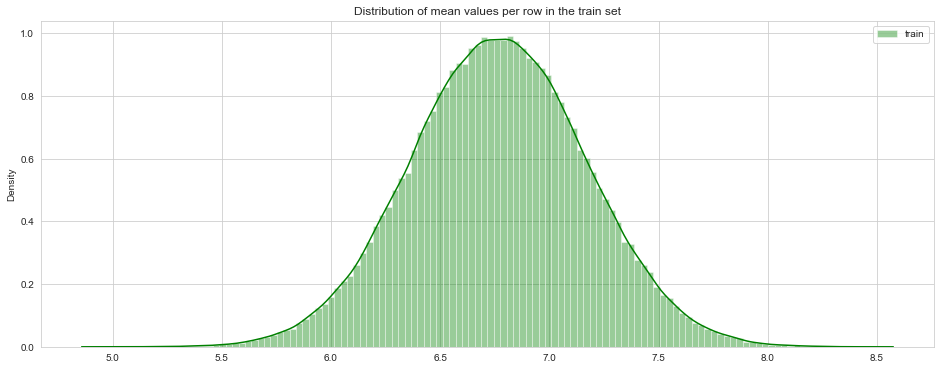

In [10]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of mean values per row in the train set")
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
plt.legend()
plt.show()

Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target.

d:\python机器学习\其他\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\python机器学习\其他\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


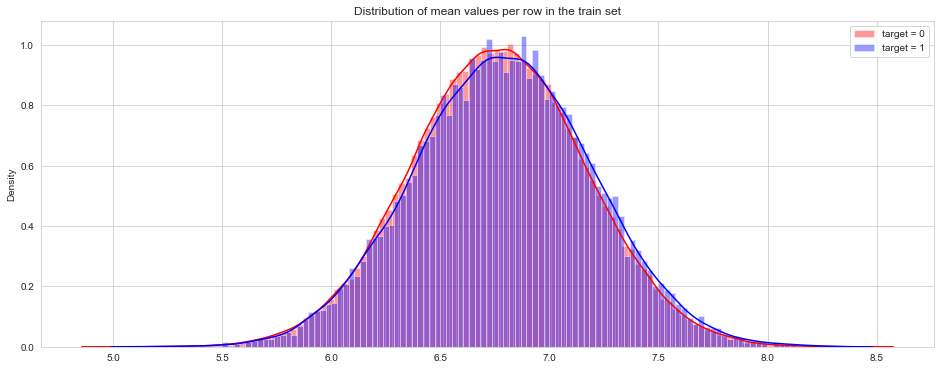

In [11]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### Features correlation
We calculate now the correlations between the features in train set.

Let's look the top most correlated features, besides the same feature pairs.

In [12]:
correlations = train[features].corr()

In [13]:
correlations

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,-0.002613,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,-0.000832,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,-0.001932,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,-0.000826,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
var_4,0.001326,0.000303,0.000723,-0.000322,1.000000,-0.001368,0.000049,0.004549,0.001194,-0.000918,...,0.001514,0.004357,0.003347,0.000813,-0.000068,0.003706,0.000513,-0.000046,-0.001821,-0.000786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,-0.000868,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,0.000052,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,0.003701,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,0.002343,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


In [14]:
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()# 求出协方差矩阵
correlations
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


## Getting Acquainted with the Gaussian Mixture Model
The Gaussian mixture model gives a mixture of normal distrubutions. We can use **sklearn.mixture.GaussianMixture** to fit the data and compare it with the histogram to get a feel of its behaviour. We also need to standardize the features because too narrow data can impair the fitting ability of the Gaussian mixture model. There are two important hyperparameters: n_components is the number of normal distributions to mix in and reg_covar is a regularization parameter that controls the spread of the bumps. Note that **score_samples** method gives the log density, so we need to exponentiate to get the density.

## Implementing the Model
We are going to use the Gaussian mixture model to estimate the likelihood probability density functions $f_{X_i|Y}(x_i|y)$.Since multiplying a lot of small numbers will lead to underflow, we take the logarithm and turn products into sums.
$$\ln p_{Y|X_0,X_1,\ldots,X_{199}}(y|x_0,x_1,\ldots,x_{199})=\underbrace{\overbrace{\ln p_Y(y)}^\text{log prior}+\overbrace{\sum_{i=0}^{199}\ln f_{X_i|Y}(x_i|y)}^\text{log likelihood}}_\text{log joint}-\overbrace{\ln\sum_{y'=0}^1e^{\ln p_Y(y')+\sum_{i=0}^{199}\ln f_{X_i|Y}(x_i|y')}}^\text{log marginal}$$
Key points in the implementation are:
+ The log prior is set as the logarithm of the proportion of different classes.
+ The log likelihood is computed by using **sklearn.mixture.GaussianMixture's score_samples** method.
+ Computing the log marginal is prone to overflow/underflow, so we use **scipy.special.logsumexp** to avoid that.
+ In the end, we convert back to probability by exponentiation.

All the heavy lifting is done by the Gaussian mixture model. The rest of the computation is very simple and fast.

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # 设定图片有多少行，多少列，用于后面向每个格子中填充数据
    plt.imshow(cm, cmap=cmap)  # 四舍五入 interpolation='nearest'

    # 设置标题，以及颜色条
    plt.title(title)
    plt.colorbar()

    # 分为设置x方向和y方向有多少个分类，以及每个分类显示的名称
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    # 判断是否需要归一化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
a = [np.random.randint(0,10) for i in range(16)]
print(a)

[4, 3, 2, 7, 2, 4, 2, 4, 9, 1, 1, 0, 9, 6, 1, 9]


In [17]:
a =np.array(a).reshape(4,4)

In [18]:
a

array([[4, 3, 2, 7],
       [2, 4, 2, 4],
       [9, 1, 1, 0],
       [9, 6, 1, 9]])

In [19]:
a[[True,True,False,False],0:1]

array([[4],
       [2]])

In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp

class GaussianMixtureNB(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1, reg_covar=1e-06):
        self.n_components = n_components #有几个高斯函数
        self.reg_covar = reg_covar #正则化

    def fit(self, X, y):
        self.log_prior_ = np.log(np.bincount(y) / len(y)) #计算每个类型的y在y中出现的频率，然后取对数
        # shape of self.log_pdf_
        shape = (len(self.log_prior_), X.shape[1]) #前面是y的种类，后面是指标
        self.log_pdf_ = [[GaussianMixture(n_components=self.n_components,
                                          reg_covar=self.reg_covar) #
                          .fit(X[y == i, j:j + 1]) #这个是在使用em算法对模型的参数进行训练,score_, 前一个参数表示样本值，后一个表示特征数
                          .score_samples for j in range(shape[1])] #针对每个类型的每种中标，建立一个GaussianMixture,一个模型有多少个高斯函数，取决于N
                         for i in range(shape[0])] #i表示种类

    def predict_proba(self, X):
        # shape of log_likelihood before summing
        shape = (len(self.log_prior_), X.shape[1], X.shape[0])#第一个表示种类，第二个表示指标，第三个表示样本量
        log_likelihood = np.sum([[self.log_pdf_[i][j](X[:, j:j + 1])
                                  for j in range(shape[1])]
                                 for i in range(shape[0])], axis=1).T##似然计算
        log_joint = self.log_prior_ + log_likelihood
        return np.exp(log_joint - logsumexp(log_joint, axis=1, keepdims=True))# 得到每种类型的概率
        
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)#返回概率最大的

## Training and Evaluating the Model
We train and evaluate the model by using the training AUC and validation AUC. The process can take time because we train the Gaussian mixture model 400 times, and the training time will increase with higher n_components. In order to speed up the hyperparameter search, we use validation, which is k times faster than k-fold cross-validation. Feel free to use cross-validation if you have the time (and tell me if you find better hyperparameters).

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

i_train, i_valid = next(StratifiedShuffleSplit(n_splits=1).split(X_train, y_train))

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

train_start_time = time.time()
pipeline = make_pipeline(StandardScaler(),
                         GaussianMixtureNB(n_components=10, reg_covar=0.03))
pipeline.fit(X_train[i_train], y_train[i_train])
train_fit_end_time = time.time()
print('time of model fitting : ',time.strftime('%H:%M:%S',time.gmtime(train_fit_end_time-train_start_time)))
pipeline.score(X_train[i_valid],y_train[i_valid]) # Evaluate the accuracy
train_score_end_time = time.time()
print('time fo scoreing : ',time.strftime('%H:%M:%S',time.gmtime(train_score_end_time-train_fit_end_time)))
print('Training AUC is {}.'
      .format(roc_auc_score(y_train[i_train],
                            pipeline.predict_proba(X_train[i_train])[:, 1])))
print('Validation AUC is {}.'
      .format(roc_auc_score(y_train[i_valid],
                            pipeline.predict_proba(X_train[i_valid])[:, 1])))

time of model fitting :  00:03:29
time fo scoreing :  00:00:04
Training AUC is 0.9076370784237823.
Validation AUC is 0.9004475952643675.


In [35]:
from sklearn import metrics
import itertools
print('打印混淆矩阵。。。。。。')
predicted = pipeline.predict(X_train[i_valid])
confusion_mtx = metrics.confusion_matrix(predicted, y_train[i_valid],labels=[1,0])
print(confusion_mtx)
acc = (confusion_mtx[0,0]+confusion_mtx[1,1])/confusion_mtx.sum()
tpr = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[0,1]) #也叫查全率(召回率),100个正实例中，找对了多少个，所以要比较大
fpr = confusion_mtx[1,0]/(confusion_mtx[1,0]+confusion_mtx[1,1]) # 100个负实例当中，有多少个被判正了,所以要比较小
ppv = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[1,0]) #也叫精确率，也就是100个被判断为正实例当中，有多少个是真正的正实例，所以要比较小
f1_score = 2*(tpr*ppv)/(tpr+ppv)
print('acc is {}, tpr is {}, fpr is {}, ppv is {}, f1-score is {}'.format(acc,tpr,fpr,ppv,f1_score))##tpr查全率和fpr查准率都很低

打印混淆矩阵。。。。。。
[[  723   241]
 [ 1287 17749]]
acc is 0.9236, tpr is 0.75, fpr is 0.06760874133221265, ppv is 0.3597014925373134, f1-score is 0.4862138533960995


In [34]:
a = np.array([1,1,1,1,0,0,0,0])
b = np.array([1,1,1,1,0,0,0,1])
confusion_mtx = confusion_mtx = metrics.confusion_matrix(a,b,labels=[1,0])
print(confusion_mtx)
acc = (confusion_mtx[0,0]+confusion_mtx[1,1])/confusion_mtx.sum()
tpr = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[0,1]) #也叫查全率(召回率),100个正实例中，找对了多少个
fpr = confusion_mtx[1,0]/(confusion_mtx[1,0]+confusion_mtx[1,1]) # 100个负实例当中，有多少个被判正了
ppv = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[1,0]) #也叫精确率，也就是100个被判断为正实例当中，有多少个是真正的正实例
f1_score = 2*(tpr*ppv)/(tpr+ppv)
print('acc is {}, tpr is {}, fpr is {}, ppv is {}, f1-score is {}'.format(acc,tpr,fpr,ppv,f1_score))##tpr查全率和fpr查准率都很低

[[4 0]
 [1 3]]
acc is 0.875, tpr is 1.0, fpr is 0.25, ppv is 0.8, f1-score is 0.888888888888889


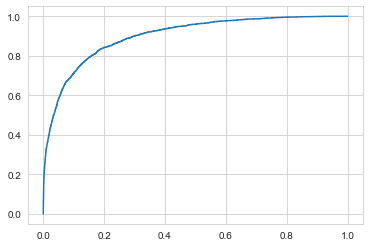

In [49]:
#打印roc
fpr,tpr,thresholds = metrics.roc_curve(y_train[i_valid],pipeline.predict_proba(X_train[i_valid])[:,1])
plt.plot(fpr,tpr)

In [29]:
len(y_train[y_train==0])/len(y_train)

0.89951

In [77]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

clf = make_pipeline(StandardScaler(),GaussianMixtureNB(n_components=10, reg_covar=0.03))
scores = cross_validate(clf, X_train[i_valid], y_train[i_valid],cv=7)
sorted(scores.keys())

['fit_time', 'score_time', 'test_score']